# Chapter 5d: 2-D CNN applications to seismic wave data

In the last jupyter notebook of chapter 5, you will apply everything that you have learned to develop, on your own, two 2-D CNN applications on seismic waveform data. We will once again use the STEAD catalogue. The two applications are the following:

* **Classification problem**: Discrimination between earthquake signal and noise: Can we do better than the ANN of chapter 4d?
* **Regression problem**: P-wave arrival picking: Can we do better than the 1-D CNN of chapter 5c?

Very little information is provided to you in this notebook. The expected results are however displayed to guide you.

In [235]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as plt_col

import h5py
import glob
import csv

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, Conv2D, MaxPooling2D

import statistics as stat

import warnings
warnings.filterwarnings('ignore')

## 1. Load, filter & visualize STEAD dataset

We already used the _STanford EArthquake Dataset_ (STEAD) twice, in chapter 4d and chapter 5c.

**EXERCISE 1:** Load the STEAD catalogue and define an `EQ_list` and `noise_list` as done in chapter 4d.

In [236]:
# YOUR CODE HERE
## modified from https://github.com/smousavi05/STEAD ##
file_name_noise = "chunk1.hdf5"
csv_file_noise = "chunk1.csv"
file_name = "chunk2.hdf5"
csv_file = "chunk2.csv"

# reading the csv file into a dataframe:
df_noise_tmp = pd.read_csv(csv_file_noise)
print(f'total events in csv file: {len(df_noise_tmp)}')
df_EQ_tmp = pd.read_csv(csv_file)
print(f'total events in csv file: {len(df_EQ_tmp)}')

# filterering the dataframe
df_EQ = df_EQ_tmp[(df_EQ_tmp.trace_category == 'earthquake_local') & (df_EQ_tmp.source_distance_km <= 20) & (df_EQ_tmp.source_magnitude > 3)]
df_noise = df_noise_tmp[(df_noise_tmp.trace_category == 'noise') & (df_noise_tmp.receiver_code == 'PHOB') ]
print(f'total earthquake time series selected: {len(df_EQ)}')
print(f'total noise time series selected: {len(df_noise)}')

# making a list of trace names for the selected data
EQ_list = df_EQ['trace_name'].to_list()
noise_list = df_noise['trace_name'].to_list()[:200]

total events in csv file: 235426
total events in csv file: 200000
total earthquake time series selected: 268
total noise time series selected: 468


## 2. Earthquake discrimination

Recall from chapter 4d that we followed there the approach developed by Dowla et al. (1990) to discriminate between earthquakes and noise. In that case, the frequencies of the seismic waveform spectrum were used as the input nodes of a feed-forward ANN. We used a _periodogram_, which is an estimate of the spectral density of a signal. It can be computed using `periodogram` from `scipy.signal`.

You will do something similar here but using a 2-D CNN. Hence, you also need to use an image as input. Instead of the periodogram (with frequency as $x$-axis and power spectral density as $y$-axis), we can use a _spectrogram_ which is like an image of a signal, which can then be used as input for computer vision. It plots time in $x$-axis and frequencies in $y$-axis and also conveys the signal strength using the colors – brighter the color the higher the energy of the signal. A spectrogram explains how the signal strength is distributed in every frequency found in the signal.

In other words, a spectrogram is a visual way of representing the signal strength, or “loudness”, of a signal over time at various frequencies present in a particular waveform.  Not only can one see whether there is more or less energy at, for example, 2 Hz vs 10 Hz, but one can also see how energy levels vary over time.  In other domains, spectrograms are commonly used to display frequencies of sound waves produced by humans, machinery, animals, whales, jets, etc., as recorded by microphones. In the seismic world, spectrograms are increasingly being used to look at frequency content of continuous signals recorded by individual or groups of seismometers to help distinguish and characterize different types of earthquakes or other vibrations in the earth. 

The python module `Matplotlib.pyplot` provides the `specgram(data, Fs = sampling_rate)` method which takes a signal as an input and plots the spectrogram. It uses Fast Fourier Transform (FFT) to get the frequencies present in the signal.

**EXERCISE 2:** For one earthquake, plot the seismic waveform per channel (E, N, Z) as well as the matching spectrogram, i.e. 6 subplots. Plot also the P arrival time. For the spectrogram, use for instance `cmap='gist_earth'` for a good contrasted display. _Hint:_ index divided by sampling rate gives you the time of occurrence.

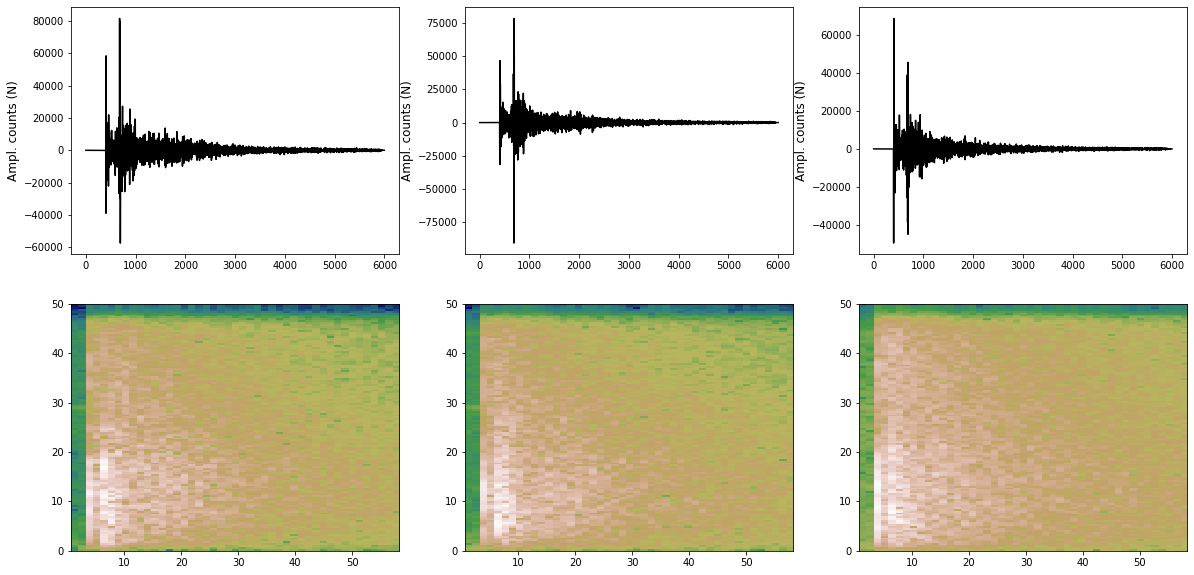

In [237]:
sampling_rate = 100    #Hz

# YOUR CODE HERE
## from https://github.com/smousavi05/STEAD ##

# retrieving selected waveforms from the hdf5 file: 
evi = EQ_list[0]
dtfl = h5py.File(file_name, 'r')
dataset = dtfl.get('data/' + str(evi)) 

# waveforms, 3 channels: first row: E channel, second row: N channel, third row: Z channel 
data = np.array(dataset)

fig = plt.figure(figsize = (20,10))
ax = fig.add_subplot(231)
plt.plot(data[:,0], 'k')
legend_properties = {'weight':'bold'}
ymin, ymax = ax.get_ylim()
plt.ylabel('Ampl. counts (N)', fontsize=12) 

ax = fig.add_subplot(232)
plt.plot(data[:,1], 'k')
legend_properties = {'weight':'bold'}
ymin, ymax = ax.get_ylim()
plt.ylabel('Ampl. counts (N)', fontsize=12) 

ax = fig.add_subplot(233)
plt.plot(data[:,2], 'k')
legend_properties = {'weight':'bold'}
ymin, ymax = ax.get_ylim()
plt.ylabel('Ampl. counts (N)', fontsize=12) 

ax = fig.add_subplot(234)
a = plt.specgram(data[:,0], Fs = sampling_rate, cmap = 'gist_earth')

ax = fig.add_subplot(235)
a = plt.specgram(data[:,1], Fs = sampling_rate, cmap = 'gist_earth')

ax = fig.add_subplot(236)
a = plt.specgram(data[:,2], Fs = sampling_rate, cmap = 'gist_earth')

 


**EXERCISE 3:** Do the same for a noise event.

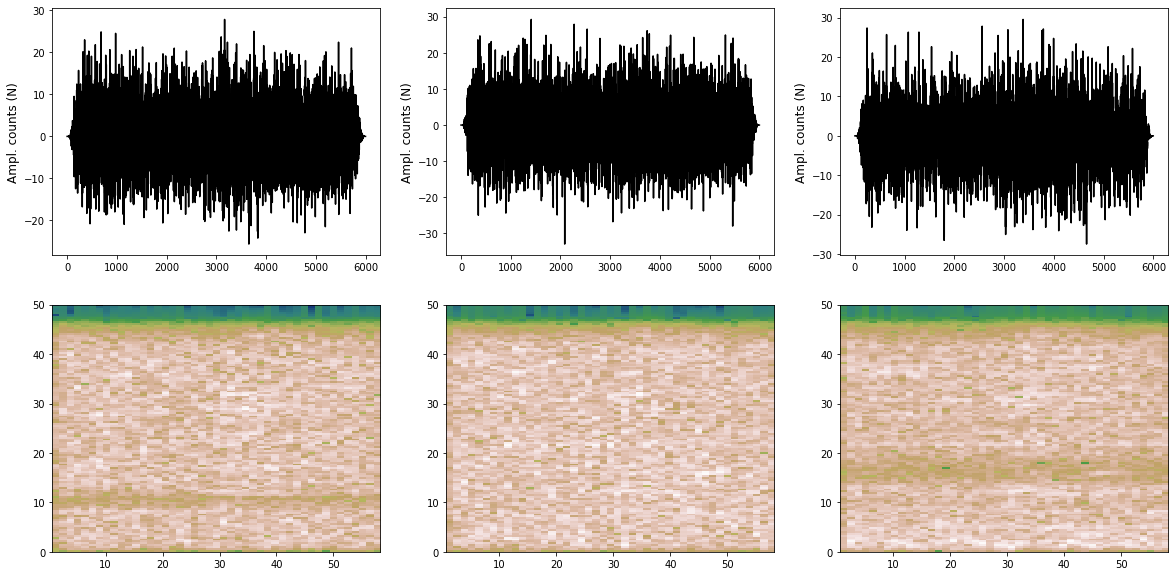

In [238]:
# YOUR CODE HERE

sampling_rate = 100    #Hz

# YOUR CODE HERE
## from https://github.com/smousavi05/STEAD ##

# retrieving selected waveforms from the hdf5 file: 
evi = noise_list[0]
dtfl = h5py.File(file_name_noise, 'r')
dataset = dtfl.get('data/' + str(evi)) 

# waveforms, 3 channels: first row: E channel, second row: N channel, third row: Z channel 
data = np.array(dataset)

fig = plt.figure(figsize = (20,10))
ax = fig.add_subplot(231)
plt.plot(data[:,0], 'k')
legend_properties = {'weight':'bold'}
ymin, ymax = ax.get_ylim()
plt.ylabel('Ampl. counts (N)', fontsize=12) 

ax = fig.add_subplot(232)
plt.plot(data[:,1], 'k')
legend_properties = {'weight':'bold'}
ymin, ymax = ax.get_ylim()
plt.ylabel('Ampl. counts (N)', fontsize=12) 

ax = fig.add_subplot(233)
plt.plot(data[:,2], 'k')
legend_properties = {'weight':'bold'}
ymin, ymax = ax.get_ylim()
plt.ylabel('Ampl. counts (N)', fontsize=12) 

ax = fig.add_subplot(234)
a = plt.specgram(data[:,0], Fs = sampling_rate, cmap = 'gist_earth')

ax = fig.add_subplot(235)
a = plt.specgram(data[:,1], Fs = sampling_rate, cmap = 'gist_earth')

ax = fig.add_subplot(236)
a = plt.specgram(data[:,2], Fs = sampling_rate, cmap = 'gist_earth')

 


**EXERCISE 4:** Investigate the structure of one spectrogram and reformat it so that it can be used as input for a 2-D CNN. For sake of simplicity, only use the first channel (i.e. E). _Hints:_

* To get the values given by `plt.specgram`, write `values, ybins, xbins, im = plt.specgram(...)`
* If you plot directly the values as follows: `plt.pcolormesh(xbins, ybins, values)`, you will not get the same image. This is due to the fact that `plt.specgram` first converts the values to decibels, i.e. `10 * np.log10(values)`. In this study, use decibels as input.
* Have a look at some potential results, printed below to guide you.

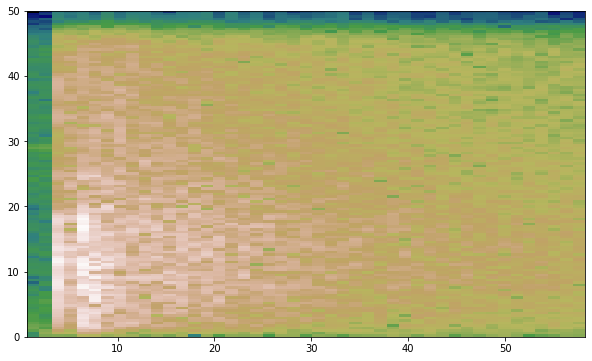

In [239]:
# YOUR CODE HERE

# retrieving selected waveforms from the hdf5 file: 
evi = EQ_list[0]
dtfl = h5py.File(file_name, 'r')
dataset = dtfl.get('data/' + str(evi)) 

# waveforms, 3 channels: first row: E channel, second row: N channel, third row: Z channel 
data = np.array(dataset)

values, ybins, xbins, im = plt.specgram(data[:,0], Fs = sampling_rate, cmap = 'gist_earth')



Text(0.5, 1.0, 'plt.pcolormesh')

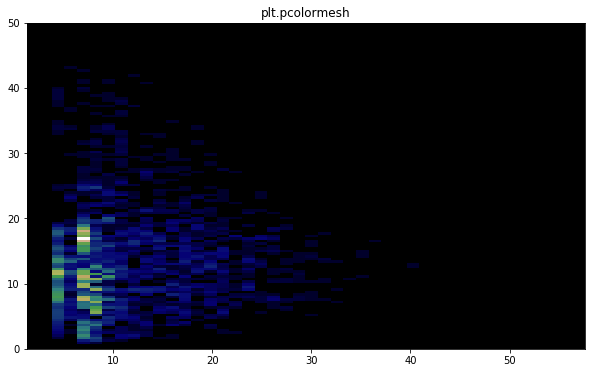

In [240]:
# YOUR CODE HERE
plt.pcolormesh(xbins, ybins, values, cmap = 'gist_earth')
plt.title('plt.pcolormesh')

Text(0.5, 1.0, 'plt.pcolormesh using decibels')

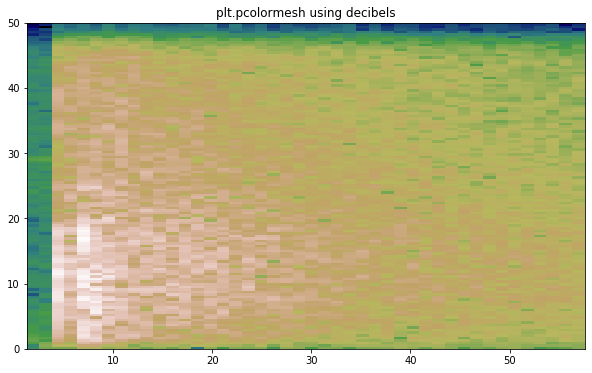

In [241]:
# YOUR CODE HERE
plt.pcolormesh(xbins, ybins, 10 * np.log10(values), cmap = 'gist_earth')
plt.title('plt.pcolormesh using decibels')

In [242]:
X_sample = 10 * np.log10(values)
print('X sample shape:', X_sample.shape)
print('X value range:', [np.min(X_sample), np.max(X_sample)])
X_sample_norm = (X_sample - np.min(X_sample)) / (np.max(X_sample) - np.min(X_sample))
print('X normalised:', [np.min(X_sample_norm), np.max(X_sample_norm)])
X_sample_norm_reshaped = X_sample_norm.reshape(X_sample_norm.shape[0], X_sample_norm.shape[1], 1)
print('X sample shape (after adding 1 channel):', X_sample_norm_reshaped.shape)

X sample shape: (129, 45)
X value range: [-73.3518729298451, 75.64567773709126]
X normalised: [0.0, 1.0]
X sample shape (after adding 1 channel): (129, 45, 1)


**EXERCISE 5:** Prepare your data `X_EQ` by looping on a subselection of the earthquakes, then `X_noise` by looping on all the noise events. _Hints:_ The final shape of your data should be (# samples, width, height, # channels). As indicated previously, we only use 1 channel. We did something similar back in chapter 4d. By subselection, it means that you should use a balanced dataset.

In [243]:
n_ = len(noise_list) # looping on all the noise events, but looping on a subselection of the earthquakes

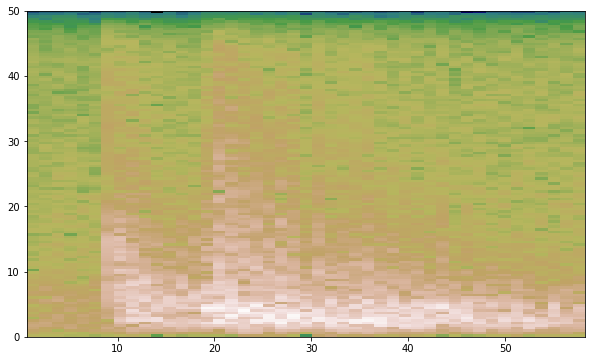

In [244]:
X_EQ = np.empty(shape = ( n_, len(ybins), len(xbins), 1))
for i_ in range(n_):
    # retrieving selected waveforms from the hdf5 file: 
    evi = EQ_list[i_]
    dtfl = h5py.File(file_name, 'r')
    dataset = dtfl.get('data/' + str(evi)) 

    # waveforms, 3 channels: first row: E channel, second row: N channel, third row: Z channel 
    data = np.array(dataset)

    values, ybins, xbins, im = plt.specgram(data[:,0], Fs = sampling_rate, cmap = 'gist_earth')
    
    X_EQ[i_,:,:,0] = 10 * np.log10(values)

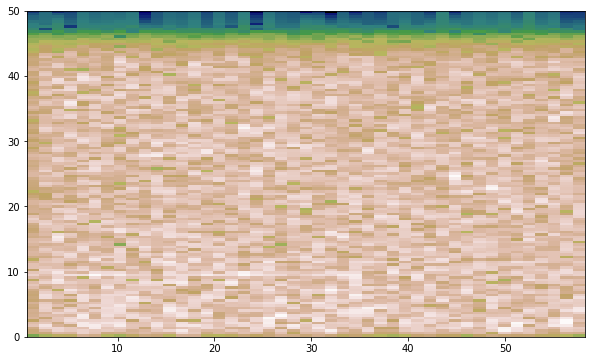

In [245]:
X_noise = np.empty(shape = (n_, len(ybins), len(xbins), 1))
for i_ in range(n_):
    # retrieving selected waveforms from the hdf5 file: 
    evi = noise_list[i_]
    dtfl = h5py.File(file_name_noise, 'r')
    dataset = dtfl.get('data/' + str(evi)) 

    # waveforms, 3 channels: first row: E channel, second row: N channel, third row: Z channel 
    data = np.array(dataset)

    values, ybins, xbins, im = plt.specgram(data[:,0], Fs = sampling_rate, cmap = 'gist_earth')
    
    X_noise[i_,:,:,0] = 10 * np.log10(values)

**EXERCISE 6:** Now concatenate `X_EQ` and `X_noise` into `X`. Define `y` also, with class 0 for noise events and class 1 for earthquakes. Then, define `X_train`, `X_test`, `y_train` and `y_test` with 50-50 split. Use `random_state = 4` to be able to compare with your colleagues and the results shown in the notebook. Finally, apply `tf.keras.utils.to_categorical()` to `y_train` and `y_test`. _Hint:_ For concatenation, have a look in chapter 4d (exercise 6). 

In [246]:
X = np.concatenate([X_EQ, X_noise], axis=0)
y = np.concatenate([np.ones(n_),np.zeros(n_)],axis = 0)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size =0.5,random_state = 4)

y_train = tf.keras.utils.to_categorical(y_train)
y_test = tf.keras.utils.to_categorical(y_test)

In [247]:
# YOUR CODE HERE
print('X_train shape:',X_train.shape)
print('X_test shape:',X_test.shape)
print('y_train shape:',y_train.shape)
print('y_test shape:',y_train.shape)

X_train shape: (200, 129, 45, 1)
X_test shape: (200, 129, 45, 1)
y_train shape: (200, 2)
y_test shape: (200, 2)


**EXERCISE 7:** Build a CNN for the present classification problem following the architecture shown below, proposed by Curilem et al. (2018) for discrimination between 4 classes of seismic events. In our case, we have only two classes (earthquake or noise event):

<img src="figs_notebook/ref_Curilem_etal2018.png" style="width:800px;height:300px;">

CNN summary: conv. 2D, ReLU, max pool., dropout, conv. 2D, ReLU , max pool., fully-connected, ReLU, dropout, fully-connected and output layer with softmax activation function.

In [248]:
model_CNN= Sequential([
    Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=(X_train.shape[1], X_train.shape[2], X_train.shape[3])),
    MaxPooling2D((2, 2)),
    Dropout(0.15),    
    Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform'),                                                                                   
    MaxPooling2D((2, 2)),                                                                                   
    Flatten(),
    Dense(700, activation='relu', kernel_initializer='he_uniform'),
    Dropout(0.75),
    Dense(2, activation='softmax')  
           ])
model_CNN.compile(loss = 'categorical_crossentropy', metrics = ['accuracy'], optimizer = 'adam')
model_CNN.summary()






Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_30 (Conv2D)           (None, 127, 43, 32)       320       
_________________________________________________________________
max_pooling2d_30 (MaxPooling (None, 63, 21, 32)        0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 63, 21, 32)        0         
_________________________________________________________________
conv2d_31 (Conv2D)           (None, 61, 19, 64)        18496     
_________________________________________________________________
max_pooling2d_31 (MaxPooling (None, 30, 9, 64)         0         
_________________________________________________________________
flatten_15 (Flatten)         (None, 17280)             0         
_________________________________________________________________
dense_30 (Dense)             (None, 700)             

**EXERCISE 8:** Train your CNN model and evaluate the accuracy on the test set. Plot the learning curve to check if you defined a number of epochs large enough. Also display the confusion matrix. Note that because of the dropout layers, you will likely get different results at different runs of the model. _Hint:_ If the curve for the test set does not flatten, consider increasing your number of epochs. A common batch size is 32 but you may try other values.

In [249]:
# YOUR CODE HERE
results_CNN = model_CNN.fit(X_train, y_train, batch_size = 32, epochs =300,validation_data = (X_test, y_test), verbose = 0 )



print("Evaluating on testing set...")
(loss, accuracy) = model_CNN.evaluate(X_test, y_test, verbose = 0)
print("loss = {:.4f}, accuracy = {:.4f}%".format(loss, accuracy * 100))

Evaluating on testing set...
loss = 0.2023, accuracy = 99.5000%


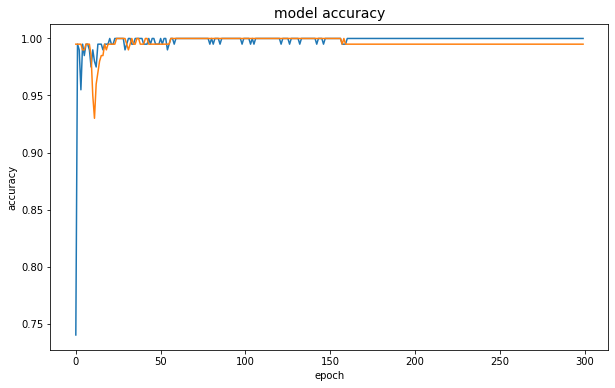

In [250]:
# YOUR CODE HERE
plt.plot(results_CNN.history['acc'])
plt.plot(results_CNN.history['val_acc'])
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('model accuracy', size=14);

In [251]:
# YOUR CODE HERE
y_pred = model_CNN.predict(X_test)
y_test_bin = np.argmax(y_test,axis =1)
y_pred = np.argmax(y_pred,axis =1)
confusion_matrix(y_test_bin,y_pred)

array([[106,   0],
       [  1,  93]], dtype=int64)

**EXERCISE 9:** You must have observed that the performance of the CNN varies a lot in successive epochs. Depending on where you stop (e.g. early stopping), your performance will differ (going up and down). It is possible that the dropout layers are the cause of this phenomenon. Redo the previous CNN, now removing both dropout layers. Retrain the new model, give the accuracy on the test set, show the learning curve and the confusion matrix. You should now obtain a much stable performance with much less epochs necessary.

In [252]:
# YOUR CODE HERE
model_CNN_nodropout_= Sequential([
    Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=(X_train.shape[1], X_train.shape[2], X_train.shape[3])),
    MaxPooling2D((2, 2)),
#     Dropout(0.15),    
    Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform'),                                                                                   
    MaxPooling2D((2, 2)),                                                                                   
    Flatten(),
    Dense(700, activation='relu', kernel_initializer='he_uniform'),
#     Dropout(0.75),
    Dense(2, activation='softmax')  
           ])
model_CNN_nodropout_.compile(loss = 'categorical_crossentropy', metrics = ['accuracy'], optimizer = 'adam')
model_CNN_nodropout_.summary()






Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_32 (Conv2D)           (None, 127, 43, 32)       320       
_________________________________________________________________
max_pooling2d_32 (MaxPooling (None, 63, 21, 32)        0         
_________________________________________________________________
conv2d_33 (Conv2D)           (None, 61, 19, 64)        18496     
_________________________________________________________________
max_pooling2d_33 (MaxPooling (None, 30, 9, 64)         0         
_________________________________________________________________
flatten_16 (Flatten)         (None, 17280)             0         
_________________________________________________________________
dense_32 (Dense)             (None, 700)               12096700  
_________________________________________________________________
dense_33 (Dense)             (None, 2)               

In [253]:
# YOUR CODE HERE

results_nodropout_ = model_CNN_nodropout_.fit(X_train, y_train, batch_size = 32, epochs =300,validation_data = (X_test, y_test), verbose = 0 )





In [254]:
print("Evaluating on testing set...")
(loss, accuracy) = model_CNN_nodropout_.evaluate(X_test, y_test, verbose = 0)
print("loss = {:.4f}, accuracy = {:.4f}%".format(loss, accuracy * 100))

Evaluating on testing set...
loss = 3.7044, accuracy = 99.5000%


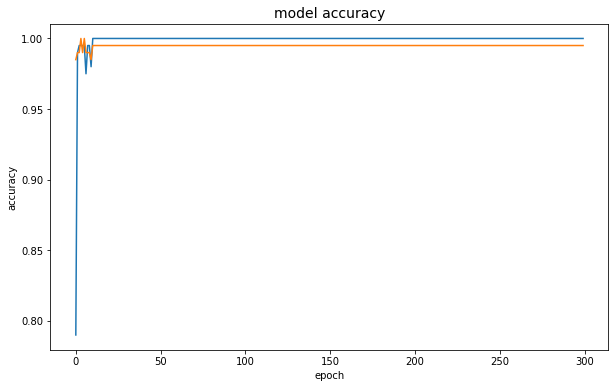

In [255]:
# YOUR CODE HERE
plt.plot(results_nodropout_.history['acc'])
plt.plot(results_nodropout_.history['val_acc'])
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('model accuracy', size=14);

In [256]:
# YOUR CODE HERE

y_pred = model_CNN_nodropout_.predict(X_test)
y_test_bin = np.argmax(y_test,axis =1)
y_pred = np.argmax(y_pred,axis =1)
confusion_matrix(y_test_bin,y_pred)

array([[105,   1],
       [  0,  94]], dtype=int64)

Notice that we did much better with a CNN than with the ANN of chapter 4d.

## 3. P-wave arrival picking

We developed a 1-D CNN in the previous jupyter notebook. Could we have used a 2-D CNN instead? This is the question you need to answer in this second application.

**EXERCISE 10:** Define a new `X` taking into account all the earthquakes available, but this time using channel Z only (i.e. the third channel). Define also a new `y`, which is now the value of the P arrival time. Then split the data into training and test sets (75-25 split). _Hint:_ Have a look at exercise 4 of chapter 5c.

(268, 129, 45, 1)

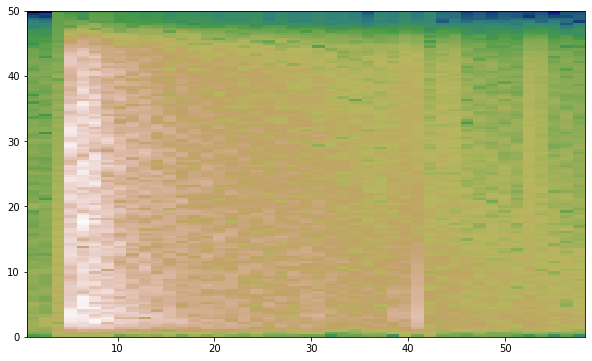

In [257]:
n_EQ = len(EQ_list)

# YOUR CODE HERE

X_EQ = np.empty(shape = ( n_EQ, len(ybins), len(xbins), 1))
for i_ in range(n_EQ):
    # retrieving selected waveforms from the hdf5 file: 
    evi = EQ_list[i_]
    dtfl = h5py.File(file_name, 'r')
    dataset = dtfl.get('data/' + str(evi)) 

    # waveforms, 3 channels: first row: E channel, second row: N channel, third row: Z channel 
    data = np.array(dataset)

    values, ybins, xbins, im = plt.specgram(data[:,2], Fs = sampling_rate, cmap = 'gist_earth')
    
    X_EQ[i_,:,:,0] = 10 * np.log10(values)



X_new = X_EQ
X_new.shape


In [258]:
y_new = np.empty(shape = (n_EQ))
for i in range(n_EQ):
    evi = EQ_list[i]
    dtfl = h5py.File(file_name, 'r')
    dataset = dtfl.get('data/' + str(evi)) 
    data_EQ = np.array(dataset)
    
    P0 = dataset.attrs['p_arrival_sample']
    
    y_new[i] = P0

In [259]:
# YOUR CODE HERE
X_train, X_test, y_train, y_test = train_test_split(X_new, y_new, test_size =0.25)
print('X_train shape:', X_train.shape)
print('X_test shape:', X_test.shape)
print('y_train shape:', y_train.shape)
print('y_test shape:', y_test.shape)

X_train shape: (201, 129, 45, 1)
X_test shape: (67, 129, 45, 1)
y_train shape: (201,)
y_test shape: (67,)


**EXERCISE 11:** Build and compile a 2-D CNN by taking inspiration from the 1-D CNN defined in the previous notebook to define the activation of the last layer and for the compiler parameterization. For the overall architecture, you may use the same one as used above in the first application of the present notebook.

In [260]:
# YOUR CODE HERE
model_CNN2= Sequential([
    Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=(X_train.shape[1], X_train.shape[2], X_train.shape[3])),
    MaxPooling2D((2, 2)),
#     Dropout(0.15),    
    Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform'),                                                                                   
    MaxPooling2D((2, 2)),                                                                                   
    Flatten(),
    Dense(700, activation='relu', kernel_initializer='he_uniform'),
#     Dropout(0.75),
    Dense(1, activation='linear') 
#     Dense(2,activation='linear')
           ])
model_CNN2.summary()

model_CNN2.compile(loss = 'mean_squared_error', metrics = ['mse'], optimizer = 'adam')

Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_34 (Conv2D)           (None, 127, 43, 32)       320       
_________________________________________________________________
max_pooling2d_34 (MaxPooling (None, 63, 21, 32)        0         
_________________________________________________________________
conv2d_35 (Conv2D)           (None, 61, 19, 64)        18496     
_________________________________________________________________
max_pooling2d_35 (MaxPooling (None, 30, 9, 64)         0         
_________________________________________________________________
flatten_17 (Flatten)         (None, 17280)             0         
_________________________________________________________________
dense_34 (Dense)             (None, 700)               12096700  
_________________________________________________________________
dense_35 (Dense)             (None, 1)               

**EXERCISE 12:** Train the model, predict on the test set, and print the standard deviation of the residual between predicted and observed P wave arrivals. Plot the histogram of the residuals. Explain what the problem is. Can we use a 2-D CNN to predict the arrival time of the P wave? If so, what could be a worthwhile option to explore?

In [261]:
# YOUR CODE HERE
epochs = 800
batch_size = 200

# YOUR CODE HERE
results = model_CNN2.fit(
    X_train, y_train,
    epochs = epochs,
    validation_data = (X_test, y_test),
    batch_size = batch_size,
    verbose = 0   # 0 to hide the training progress, 1 otherwise
)


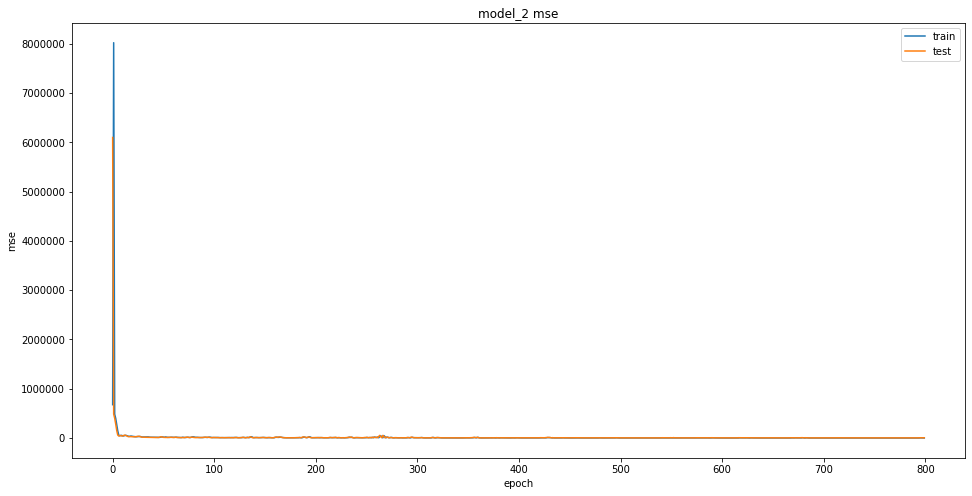

In [262]:
plt.figure(figsize = (16,8))
plt.plot(results.history['mean_squared_error'], label = 'train')
plt.plot(results.history['val_mean_squared_error'], label = 'test')
plt.title('model_2 mse')
plt.xlabel('epoch')
plt.ylabel('mse')
plt.legend()
plt.show()

In [263]:
y_pred = model_CNN2.predict(X_test)
print('standard deviation of residual = ', np.std((y_pred-y_test.reshape(67,1))/100))

standard deviation of residual =  0.6102134784856509


Text(0, 0.5, 'count')

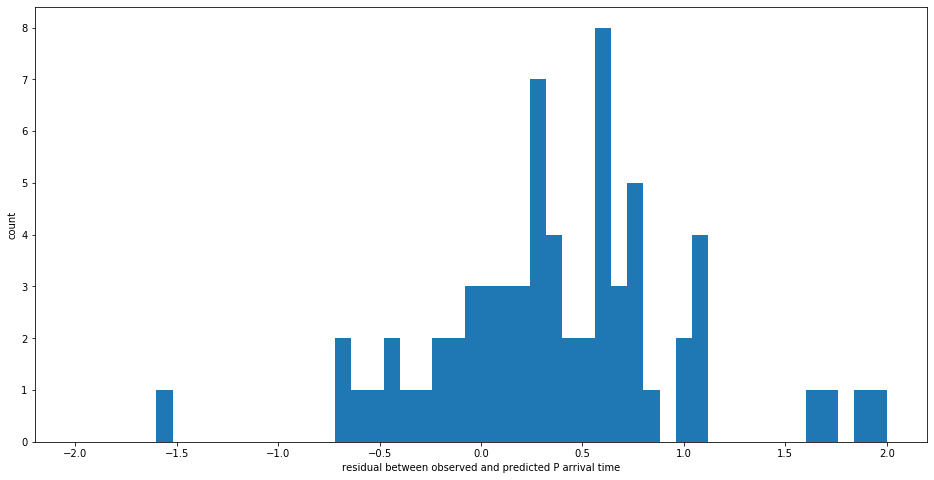

In [264]:
# plt.plot(results.history['mean_squared_error'])
plt.figure(figsize = (16,8))
plt.hist((y_pred-y_test.reshape(67,1))/100,bins = 50,range = (-2,2))
plt.xlabel('residual between observed and predicted P arrival time')
plt.ylabel('count')

YOUR ANSWER HERE

Yes,we can. We can try nomalization as we do in chap. 5c